# Coordinate-Based Meta-Analysis

In [1]:
# First, import the necessary modules and functions
import os
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
from myst_nb import glue
from nilearn import plotting

import nimare

# Define where data files will be located
DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

# Now, load the Datasets we will use in this chapter
sleuth_dset1 = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "sleuth_dset1.pkl.gz"))
sleuth_dset2 = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "sleuth_dset2.pkl.gz"))
neurosynth_dset = nimare.dataset.Dataset.load(os.path.join(DATA_DIR, "neurosynth_dataset.pkl.gz"))

/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Coordinate-based meta-analysis (CBMA) is currently the most popular method for neuroimaging meta-analysis, given that the majority of fMRI papers currently report their findings as peaks of statistically significant clusters in standard space and do not release unthresholded statistical maps.
These peaks indicate where significant results were found in the brain, and thus do not reflect an effect size estimate for each hypothesis test (i.e., each voxel) as one would expect for a typical meta-analysis.
As such, standard methods for effect size-based meta-analysis cannot be applied.
Over the past two decades, a number of algorithms have been developed to determine whether peaks converge across experiments in order to identify locations of consistent or specific activation associated with a given hypothesis {cite:p}`Samartsidis2017-ej,Muller2018-mt`.

Kernel-based methods evaluate convergence of coordinates across studies by first convolving foci with a spatial kernel to produce study-specific modeled activation maps, then combining those modeled activation maps into a sample-wise map, which is compared to a null distribution to evaluate voxel-wise statistical significance.
Additionally, for each of the following approaches, except for SCALE, voxel- or cluster-level multiple comparisons correction may be performed using Monte Carlo simulations or false discovery rate (FDR) {cite:p}`Laird2005-qh` correction. Basic multiple-comparisons correction methods (e.g., Bonferroni correction) are also supported.

```{figure} images/figure_02.png
:figwidth: 150px
:name: meta_workflow_fig
:align: center

A flowchart of the typical workflow for coordinate-based meta-analyses in NiMARE.
```

## CBMA kernels

CBMA kernels are available as {py:class}`nimare.meta.kernel.KernelTransformer`s in the {py:mod}`nimare.meta.kernel` module.
There are three standard kernels that are currently available: {py:class}`nimare.meta.kernel.MKDAKernel`, {py:class}`nimare.meta.kernel.KDAKernel`, and {py:class}`nimare.meta.kernel.ALEKernel`.
Each class may be configured with certain parameters when a new object is initialized.
For example, `MKDAKernel` accepts an `r` parameter, which determines the radius of the spheres that will be created around each peak coordinate.
`ALEKernel` automatically uses the sample size associated with each experiment in the `Dataset` to determine the appropriate full-width-at-half-maximum of its Gaussian distribution, as described in {cite:t}`EICKHOFF20122349`; however, users may provide a constant `sample_size` or `fwhm` parameter when sample size information is not available within the `Dataset` metadata.

Here we show how these three kernels can be applied to the same `Dataset`.

In [2]:
from nimare.meta import kernel

mkda_kernel = kernel.MKDAKernel(r=10)
mkda_ma_maps = mkda_kernel.transform(sleuth_dset1)
kda_kernel = kernel.KDAKernel(r=10)
kda_ma_maps = kda_kernel.transform(sleuth_dset1)
ale_kernel = kernel.ALEKernel(sample_size=20)
ale_ma_maps = ale_kernel.transform(sleuth_dset1)

In [3]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_kernel, kda_kernel, ale_kernel

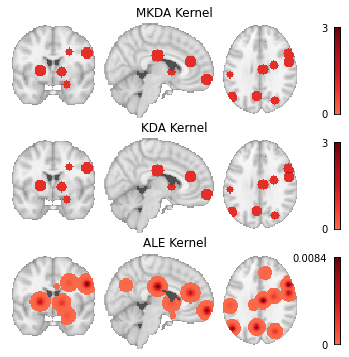

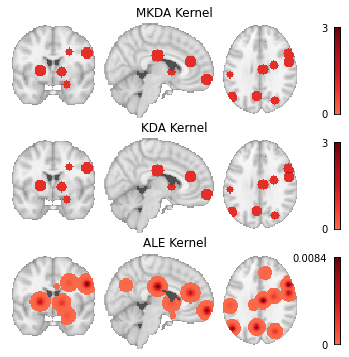

In [4]:
# Generate figure
study_idx = 10  # a study with overlapping kernels
max_value = np.max(kda_ma_maps[study_idx].get_fdata()) + 1

ma_maps = {
    "MKDA Kernel": mkda_ma_maps[study_idx],
    "KDA Kernel": kda_ma_maps[study_idx],
    "ALE Kernel": ale_ma_maps[study_idx],
}

fig, axes = plt.subplots(nrows=3, figsize=(6, 6))

for i_meta, (name, img) in enumerate(ma_maps.items()):
    if "ALE" in name:
        vmax = None
    else:
        vmax = max_value

    display = plotting.plot_stat_map(
        img,
        annotate=False,
        axes=axes[i_meta],
        cmap="Reds",
        cut_coords=[5, 0, 29],
        draw_cross=False,
        figure=fig,
        vmax=vmax,
    )
    axes[i_meta].set_title(name)

    colorbar = display._cbar
    colorbar_ticks = colorbar.get_ticks()
    if colorbar_ticks[0] < 0:
        new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
    else:
        new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
    colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_ma_maps", fig, display=False)

In [5]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_ma_maps, kda_ma_maps, ale_ma_maps

```{glue:figure} figure_ma_maps
:figwidth: 300px
:name: "figure_ma_maps"
:align: center

Modeled activation maps produced by NiMARE's `KernelTransformer` classes.
```

(content:cbma:mkdad)=
## Multilevel kernel density analysis

**Multilevel kernel density analysis** (MKDA) {cite:p}`Wager2007-jc` is a kernel-based method that convolves each peak from each study with a binary sphere of a set radius.
These peak-specific binary maps are then combined into study-specific maps by taking the maximum value for each voxel.
Study-specific maps are then averaged across the meta-analytic sample.
This averaging is generally weighted by studies’ sample sizes, although other covariates may be included, such as weights based on the type of inference (random or fixed effects) employed in the study’s analysis.
An arbitrary threshold is generally employed to zero-out voxels with very low values, and then a Monte Carlo procedure is used to assess statistical significance, either at the voxel or cluster level.

In NiMARE, the MKDA meta-analyses can be performed with the {py:class}`nimare.meta.cbma.mkda.MKDADensity` class.
This class, like most other CBMA classes in NiMARE, accepts a `null_method` parameter, which determines how voxel-wise (uncorrected) statistical significance is calculated.

```{admonition} On CBMA "null methods"
:class: tip
The `null_method` parameter allows two options: "approximate" or "montecarlo."
The "approximate" option builds a histogram-based null distribution of summary-statistic values, which can then be used to determine the associated p-value for _observed_ summary-statistic values (i.e., the values in the meta-analytic map).
The "montecarlo" option builds a null distribution of summary-statistic values by randomly shuffling the coordinates the `Dataset` many times, and computing the summary-statistic values for each permutation.
In general, the "montecarlo" method is slightly more accurate when there are enough permutations, while the "approximate" method is much faster.
```

```{warning}
Fitting the CBMA `Estimator` to a `Dataset` will produce p-value, z-statistic, and summary-statistic maps, but these are not corrected for multiple comparisons.

When performing a meta-analysis with the goal of statistical inference, you will want to perform multiple comparisons correction with NiMARE's `Corrector`
classes.
Please see the multiple comparisons correction chapter for more information.
```

Here we perform an MKDADensity meta-analysis on one of the Sleuth-based Datasets.
We will use the "approximate" null method for speed.

In [6]:
from nimare.meta.cbma import mkda

mkdad_meta = mkda.MKDADensity(null_method="approximate")
mkdad_results = mkdad_meta.fit(sleuth_dset1)

(content:cbma:metaresult)=
### The `MetaResult` class

Fitting an `Estimator` to a `Dataset` produces a {py:class}`nimare.results.MetaResult` object.
The `MetaResult` class is a light container holding the different statistical maps produced by the `Estimator`.

In [7]:
print(mkdad_results)

This result is also retained as an attribute in the `Estimator`.

In [8]:
print(mkdad_meta.results)

The `maps` attribute is a dictionary containing statistical map names and associated numpy arrays.

In [9]:
pprint(mkdad_results.maps)

{'p': array([1., 1., 1., ..., 1., 1., 1.]),
 'stat': array([0., 0., 0., ..., 0., 0., 0.]),
 'z': array([0., 0., 0., ..., 0., 0., 0.])}


These arrays can be transformed into image-like objects using the `masker` attribute.
We can also use the `get_map` method to get that image object.

In [10]:
mkdad_img = mkdad_results.get_map("z", return_type="image")
print(mkdad_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code     

We can save the statistical maps to an output directory as gzipped nifti files, with a prefix.
Here, we will save all of the statistical maps with the MKDADensity prefix.

In [11]:
mkdad_results.save_maps(output_dir=DATA_DIR, prefix="MKDADensity")

We will also save the `Estimator` itself, which we will reuse when we get to multiple comparisons correction.

In [12]:
mkdad_meta.save(os.path.join(DATA_DIR, "MKDADensity.pkl.gz"))

In [13]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkdad_meta, mkdad_results

Since this is a kernel-based algorithm, the kernel transformer is an optional input to the meta-analytic estimator, and can be controlled in a more fine-grained manner.

In [14]:
# These two approaches (initializing the kernel ahead of time or
# providing the arguments with the kernel__ prefix) are equivalent.
mkda_kernel = kernel.MKDAKernel(r=2)
mkdad_meta = mkda.MKDADensity(kernel_transformer=mkda_kernel)
mkdad_meta = mkda.MKDADensity(kernel_transformer=kernel.MKDAKernel, kernel__r=2)

# A completely different kernel could even be provided, although this is not
# recommended and should only be used for testing algorithms.
mkdad_meta = mkda.MKDADensity(kernel_transformer=kernel.KDAKernel)

In [15]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkda_kernel, mkdad_meta

## Kernel density analysis

**Kernel density analysis** (KDA) {cite:p}`Wager2003-no,Wager2004-ak` is a precursor algorithm that has been replaced in the field by MKDA.
For the sake of completeness, NiMARE also includes a KDA estimator that implements the older KDA algorithm for comparison purposes.
The interface is virtually identical, but since there are few if any legitimate uses of KDA (which models studies as fixed rather than random effects), we do not discuss the algorithm further here.

In [16]:
kda_meta = mkda.KDA(null_method="approximate")
kda_results = kda_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
kda_img = kda_results.get_map("z", return_type="image")

In [17]:
# Here we delete the recent variables for the sake of reducing memory usage
del kda_meta, kda_results

## Activation likelihood estimation

**Activation likelihood estimation** (ALE) {cite:p}`Eickhoff2012-hk,Turkeltaub2012-no,Turkeltaub2002-dn` assesses convergence of peaks across studies by first generating a modeled activation map for each study, in which each of the experiment’s peaks is convolved with a 3D Gaussian distribution determined by the experiment’s sample size, and then by combining these modeled activation maps across studies into an ALE map, which is compared to an empirical null distribution to assess voxel-wise statistical significance.

In [18]:
from nimare.meta.cbma import ale

ale_meta = ale.ALE()
ale_results = ale_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
ale_img = ale_results.get_map("z", return_type="image")

In [19]:
# Here we delete the recent variables for the sake of reducing memory usage
del ale_meta, ale_results

## Specific coactivation likelihood estimation

**Specific coactivation likelihood estimation** (SCALE) {cite:p}`Langner2014-ei` is an extension of the ALE algorithm developed for meta-analytic coactivation modeling (MACM) analyses.
Rather than comparing convergence of foci within the sample to a null distribution derived under the assumption of spatial randomness within the brain, SCALE assesses whether the convergence at each voxel is greater than in the general literature.
Each voxel in the brain is assigned a null distribution determined based on the base rate of activation for that voxel across an existing coordinate-based meta-analytic database.
This approach allows for the generation of a statistical map for the sample, but no methods for multiple comparisons correction have yet been developed.
While this method was developed to support analysis of joint activation or “coactivation” patterns, it is generic and can be applied to any CBMA; see [](about_derivative_analyses.md)

In [20]:
# Here we use the coordinates from Neurosynth as our measure of coordinate
# base-rates, because we do not have access to the full BrainMap database.
# However, one assumption of SCALE is that the Dataset being analyzed comes
# from the same source as the database you use for calculating base-rates.
xyz = neurosynth_dset.coordinates[["x", "y", "z"]].values
scale_meta = ale.SCALE(n_iters=2500, xyz=xyz, memory_limit=None)
scale_results = scale_meta.fit(sleuth_dset1)

# Retain the z-statistic map for later use
scale_img = scale_results.get_map("z", return_type="image")

  0%|          | 0/2500 [00:00<?, ?it/s]

In [21]:
# Here we delete the recent variables for the sake of reducing memory usage
del xyz, scale_meta, scale_results

## MKDA Chi-Squared Analysis

An alternative to the density-based approaches (i.e., MKDA, KDA, ALE, and SCALE) is the **MKDA Chi-squared** extension {cite:p}`Wager2007-jc`.
Though still a kernel-based method in which foci are convolved with a binary sphere and combined within studies, this approach uses voxel-wise chi-squared tests to assess both consistency (i.e., higher convergence of foci within the meta-analytic sample than expected by chance) and specificity (i.e., higher convergence of foci within the meta-analytic sample than detected in an unrelated dataset) of activation.
Such an analysis also requires access to a reference meta-analytic sample or database of studies.
For example, to perform a chi-squared analysis of working memory studies, the researcher will also need a comprehensive set of studies which did not manipulate working memory—ideally one that is matched with the working memory study set on all relevant attributes _except_ the involvement of working memory.

In [22]:
mkdac_meta = mkda.MKDAChi2()
mkdac_results = mkdac_meta.fit(sleuth_dset1, sleuth_dset2)

# Retain the specificity analysis's z-statistic map for later use
mkdac_img = mkdac_results.get_map("z_desc-specificity", return_type="image")

/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:259: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nimare/meta/cbma/mkda.py:263: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * self.prior / pAgF_prior


In [23]:
# Here we delete the recent variables for the sake of reducing memory usage
del mkdac_meta, mkdac_results

## Comparing algorithms

Here we load the z-statistic map from each of the CBMA Estimators we've used throughout this chapter and plot them all side by side.

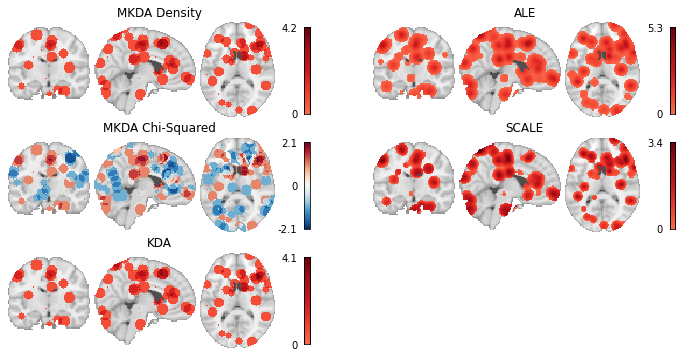

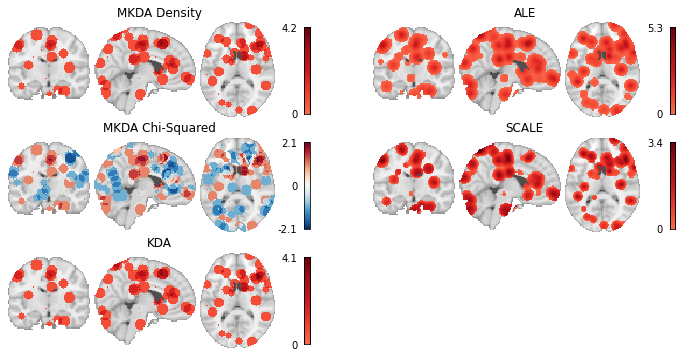

In [24]:
meta_results = {
    "MKDA Density": mkdad_img,
    "MKDA Chi-Squared": mkdac_img,
    "KDA": kda_img,
    "ALE": ale_img,
    "SCALE": scale_img,
}
order = [
    ["MKDA Density", "ALE"],
    ["MKDA Chi-Squared", "SCALE"],
    ["KDA", None]
]

fig, axes = plt.subplots(figsize=(12, 6), nrows=3, ncols=2)

for i_row, row_names in enumerate(order):
    for j_col, name in enumerate(row_names):
        if not name:
            axes[i_row, j_col].axis("off")
            continue

        img = meta_results[name]
        if name == "MKDA Chi-Squared":
            cmap = "RdBu_r"
        else:
            cmap = "Reds"

        display = plotting.plot_stat_map(
            img,
            annotate=False,
            axes=axes[i_row, j_col],
            cmap=cmap,
            cut_coords=[5, -15, 10],
            draw_cross=False,
            figure=fig,
        )
        axes[i_row, j_col].set_title(name)

        colorbar = display._cbar
        colorbar_ticks = colorbar.get_ticks()
        if colorbar_ticks[0] < 0:
            new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
        else:
            new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
        colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_cbma_uncorr", fig, display=False)

```{glue:figure} figure_cbma_uncorr
:figwidth: 300px
:name: "figure_cbma_uncorr"
:align: center

Thresholded results from MKDA Density, KDA, ALE, and SCALE meta-analyses.
```

A number of other coordinate-based meta-analysis algorithms exist which are not yet implemented in NiMARE.
We describe these algorithms briefly in [](future_directions.md).